In [4]:
### Change this so you can loop thru various days and get interesting shit. ###

### Get the most relevant skew charts for your options, and print out a nice chart! ###

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import json
import time
from pandas.io.json import json_normalize

#######################################################################

# Short dummy symbol list (for testing)
#symbol_list = ['GOOG']

symbol = 'GOOG'
url = 'https://query2.finance.yahoo.com/v7/finance/options/'
newurl = url + symbol
df = pd.read_json(newurl)
exp = json_normalize(data=df['optionChain']['result'], record_path='expirationDates')

# Temp lists for our results
optionschain = []

# A loop to get URLs + expiry dates and pull put/call data
for date in exp[0]:

    # Makes new URL with the symbol URL and expiry date
    newurl2 = newurl + '?date=' + str(date)

    # Temporary df's for our shit, written to different df later for output
    temp_df = pd.read_json(newurl2)

    chain = json_normalize(data=temp_df['optionChain']['result'], record_path='options')

    for j in chain.calls[0]:

        j.update({'type': 'call'})
        optionschain.append(j)

    for k in chain.puts[0]:

        k.update({'type': 'put'})
        optionschain.append(k)

    oc_df = pd.DataFrame(optionschain)

### DTE for expiry dates ###

exp_dte = []

# Time vars for our loops

today = time.time()
today_h = datetime.datetime.fromtimestamp(int(today)).strftime('%Y-%m-%d %H:%M:%S')

# Adds DTE to calls df

### To do: just fucking put calls and puts together, run this all at once. ###

for l in range(len(oc_df)):

    exp_h = datetime.datetime.fromtimestamp(int(oc_df['expiration'].loc[l])).strftime('%Y-%m-%d %H:%M:%S')

    today_d = datetime.datetime.strptime(today_h, "%Y-%m-%d %H:%M:%S")
    exp_d = datetime.datetime.strptime(exp_h, "%Y-%m-%d %H:%M:%S")

    dte = abs(exp_d - today_d).days

    exp_dte.append(dte)

oc_df['dte'] = exp_dte

# Adds human expiration time to puts and calls

for i in range(len(oc_df)):
    oc_df.loc[i, 'human_time'] = datetime.datetime.fromtimestamp(int(oc_df.loc[i, 'expiration'])).strftime('%Y-%m-%d %H:%M:%S')

#print(oc_df)

#######################################################################

### Modify this to import your options chain scraping module. ###

quickstats = {}

sym = oc_df

# Gets unique expriation values (UNIX and human)

exp = []
dte = []
ht = []

for i in range(len(sym['expiration'].unique())):
    exp.append(sym['expiration'].unique()[i])
    dte.append(sym['dte'].unique()[i])
    ht.append(sym['human_time'].unique()[i])

exp_df = pd.DataFrame()

exp_df['exp'] = exp
exp_df['dte'] = dte
exp_df['ht'] = ht

#print(exp_df)
#print(sym['expiration'].unique())

# Fixes using 3rd Friday expirations with plots. 

exp_dates = []

for i in sym['human_time']:
    
    exp_dates.append(i[:-9])
    
sym['exp_dates'] = exp_dates

e_d_u = sym['exp_dates'].unique()

sym['mid'] = (sym['ask'] + sym['bid']) / 2

print(sym)

        ask    bid      change contractSize       contractSymbol currency  \
0     388.0  383.0    0.000000      REGULAR  GOOG180727C00800000      USD   
1     288.9  281.5  205.120000      REGULAR  GOOG180727C00900000      USD   
2     259.1  251.6  200.280000      REGULAR  GOOG180727C00930000      USD   
3     249.7  241.7  183.780000      REGULAR  GOOG180727C00940000      USD   
4     229.8  221.8  164.810000      REGULAR  GOOG180727C00960000      USD   
5     210.5  200.9    0.000000      REGULAR  GOOG180727C00980000      USD   
6     195.5  185.8    0.000000      REGULAR  GOOG180727C00995000      USD   
7     206.3  203.1   11.630005      REGULAR  GOOG180727C01000000      USD   
8     187.4  178.9    0.000000      REGULAR  GOOG180727C01002500      USD   
9     160.2  151.7    0.000000      REGULAR  GOOG180727C01030000      USD   
10    172.2  169.3  -12.350006      REGULAR  GOOG180727C01035000      USD   
11    150.5  141.8   86.650000      REGULAR  GOOG180727C01040000      USD   

In [5]:
### This is the part you need to check out, potentially combine calls and puts for ea expiration at this part.
### Try plotting with titles of human dates and DTE.

### Note: I'm not sure why the sum of the put dict and the sum of the qs_df['puts'] column are different. ###

#sym_max = 350
#sym_min = 250

expirations = exp_df['ht']

qs_df = pd.DataFrame()

qs_df['expirations'] = expirations
qs_df['calls'] = 0
qs_df['puts'] = 0

qs_df.set_index('expirations')

call_len = {}

for i in range(len(expirations)):

    iv = sym[sym['human_time'] == expirations[i]]

    iv_call = iv[iv['type'] == 'call']
    
    call_len[expirations[i]] = len(iv_call)
    
    qs_df.loc[i, 'calls'] = len(iv_call)
    
print()

call_len['sum'] = sum(call_len.values())

print('call len dict sum # this sum is included in the dict values themselves')
print(call_len['sum'])
print()

put_len = {}

for i in range(len(expirations)):
    
    iv = sym[sym['human_time'] == expirations[i]]
    
    iv_put = iv[iv['type'] == 'put']
    
    put_len[expirations[i]] = len(put_len)
    
    qs_df.loc[i, 'puts'] = len(iv_put)
  

put_len['sum'] = sum(put_len.values())

print('put len dict sum # this sum is now included in the dict values themselves')
print(put_len['sum'])
print()
 
print('len put and call total')
print(put_len['sum'] + call_len['sum'])

quickstats['Len calls puts'] = {'calls': call_len, 'puts': put_len}

print()
print('calls to puts')
print(call_len['sum'] / put_len['sum'])

quickstats['Strikes available - Calls to puts'] = call_len['sum'] / put_len['sum']

print()

"""print('quickstats!')
print(quickstats)
print()"""

print(qs_df)

print()
print('sums: ')
print(sum(qs_df['calls']))
print(sum(qs_df['puts']))
print()
print(sum(qs_df['calls']) + sum(qs_df['puts']))

"""for i in call_len:
    print(call_len[i])
    
for i in put_len:
    print(put_len[i])"""



call len dict sum # this sum is included in the dict values themselves
942

put len dict sum # this sum is now included in the dict values themselves
66

len put and call total
1008

calls to puts
14.272727272727273

            expirations  calls  puts
0   2018-07-26 17:00:00    131   127
1   2018-08-02 17:00:00     78    84
2   2018-08-09 17:00:00     65    79
3   2018-08-16 17:00:00     95   103
4   2018-08-23 17:00:00     54    67
5   2018-08-30 17:00:00     47    57
6   2018-09-20 17:00:00    118   134
7   2018-11-15 16:00:00     10     8
8   2018-12-20 16:00:00     65    64
9   2019-01-17 16:00:00    103    96
10  2019-06-20 17:00:00     88    87
11  2020-01-16 16:00:00     88    75

sums: 
942
981

1923


'for i in call_len:\n    print(call_len[i])\n    \nfor i in put_len:\n    print(put_len[i])'

2018-07-26 17:00:00


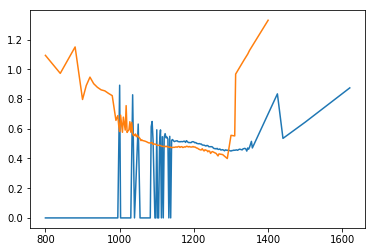

2018-08-02 17:00:00


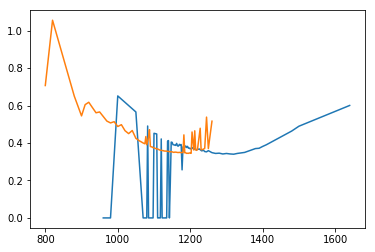

2018-08-09 17:00:00


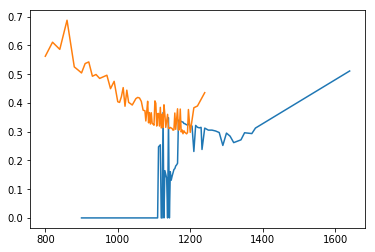

2018-08-16 17:00:00


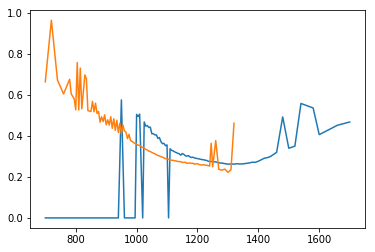

2018-08-23 17:00:00


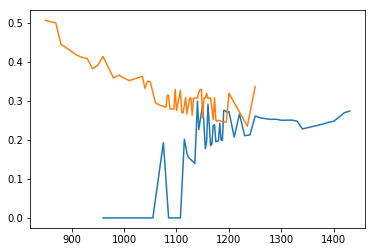

2018-08-30 17:00:00


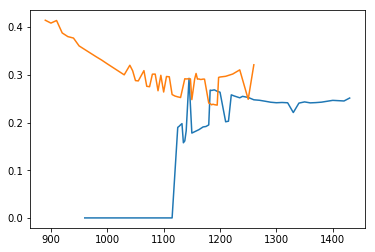

2018-09-20 17:00:00


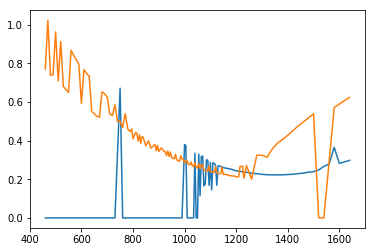

2018-11-15 16:00:00


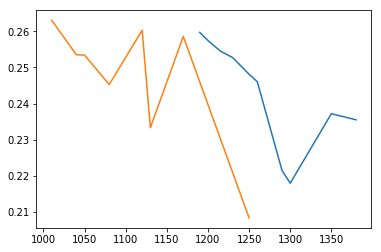

2018-12-20 16:00:00


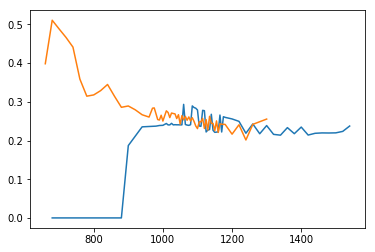

2019-01-17 16:00:00


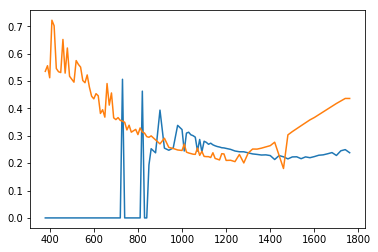

2019-06-20 17:00:00


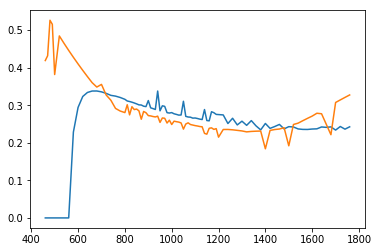

2020-01-16 16:00:00


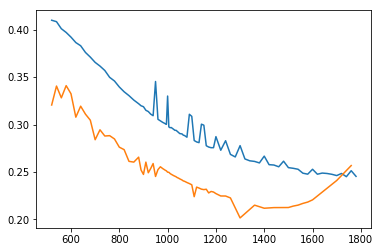

In [6]:
# Prints each plot and expirations.

for i in expirations:
    
    print(i)
    
    iv = sym[sym['human_time'] == i]
    
    iv_put = iv[iv['type'] == 'put']
    iv_call = iv[iv['type'] == 'call']
    
    plt.plot(iv_call[['strike', 'impliedVolatility']].set_index('strike'))
    plt.plot(iv_put[['strike', 'impliedVolatility']].set_index('strike'))
    
    plt.show()
    

2018-07-26 17:00:00
2018-08-02 17:00:00
2018-08-09 17:00:00
2018-08-16 17:00:00
2018-08-23 17:00:00
2018-08-30 17:00:00
2018-09-20 17:00:00
2018-11-15 16:00:00
2018-12-20 16:00:00
2019-01-17 16:00:00
2019-06-20 17:00:00
2020-01-16 16:00:00


<Figure size 432x288 with 0 Axes>

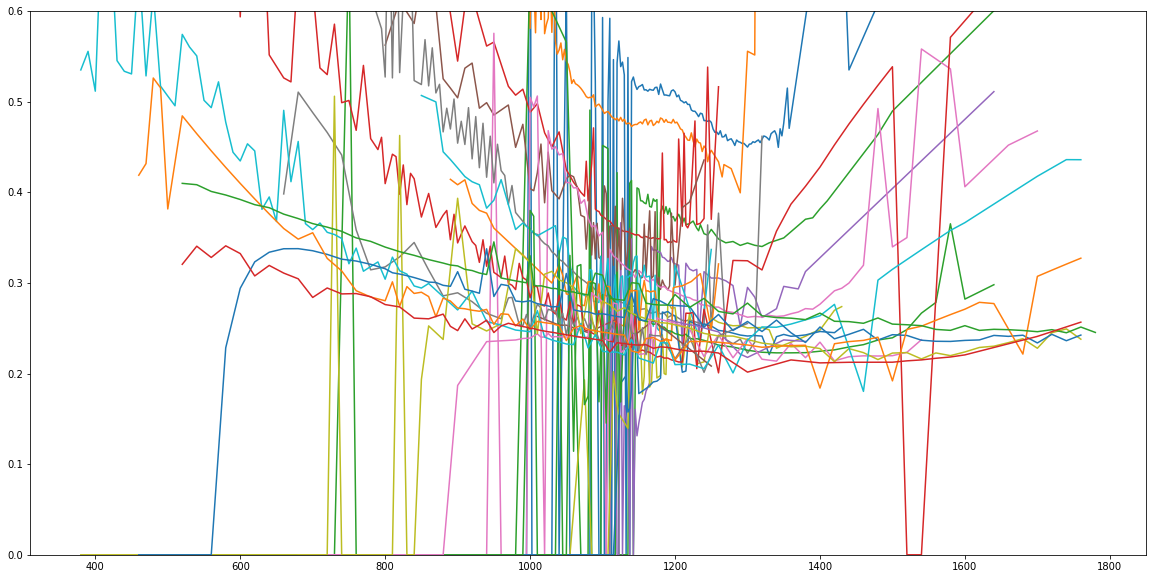

In [7]:
# Prints everything on one chart.

plt.gcf().clear()
plt.figure(figsize=(20,10))

for i in expirations:
    
    print(i)
    
    iv = sym[sym['human_time'] == i]
    
    iv_put = iv[iv['type'] == 'put']
    iv_call = iv[iv['type'] == 'call']
    
    plt.plot(iv_call[['strike', 'impliedVolatility']].set_index('strike'), label=str(i) + ' calls')
    plt.plot(iv_put[['strike', 'impliedVolatility']].set_index('strike'), label=str(i) + ' puts')
      
# figure out how to size this to a practical amount.

#plt.xlim(sym_min, sym_max)
plt.ylim(0, .6)
#plt.legend()
plt.show()

In [8]:
### Find the 3rd Friday expirations. ###

non_weeklies = []

def is_third_friday(s):
    d = datetime.datetime.strptime(s, '%Y-%m-%d')
    return d.weekday() == 3 and 15 <= d.day <= 21

for date in e_d_u:
    
    if is_third_friday(date) == True:
        
        print(date)
        non_weeklies.append(date)
        
    else:
        pass

2018-08-16
2018-09-20
2018-11-15
2018-12-20
2019-01-17
2019-06-20
2020-01-16


['2018-08-16', '2018-09-20', '2018-11-15', '2018-12-20']
2018-08-16
2018-09-20
2018-11-15
2018-12-20


<Figure size 432x288 with 0 Axes>

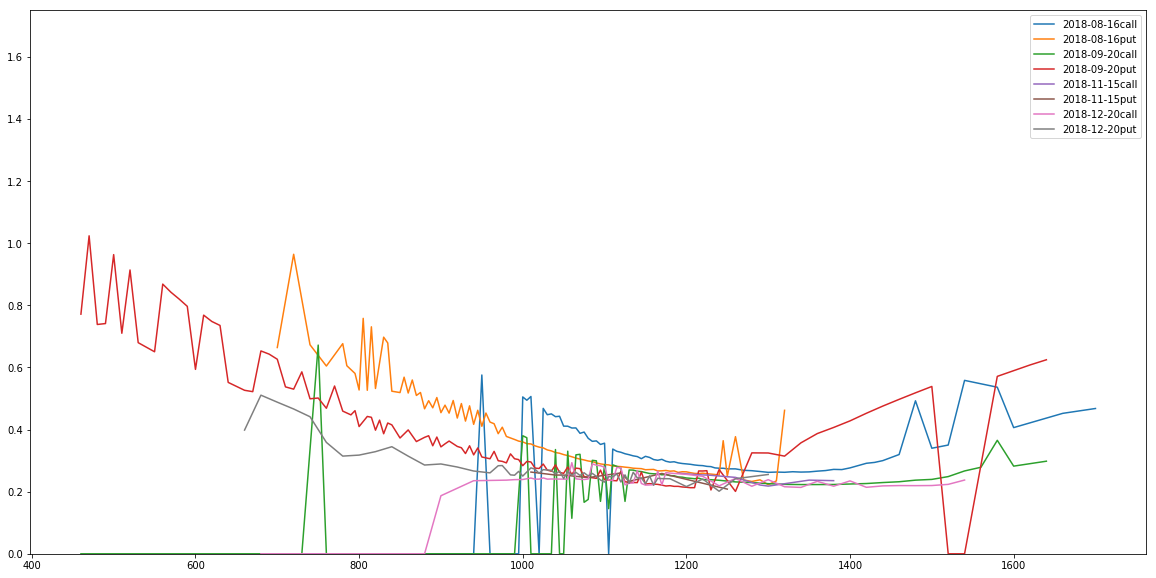

In [10]:
# Prints all non-weeklies on one chart.

plt.gcf().clear()

plt.figure(figsize=(20,10))

# Prints first 4 exp

print(non_weeklies[:4])

for i in non_weeklies[:4]:
    
    print(i)
    
    iv = sym[sym['exp_dates'] == i]
    
    iv_put = iv[iv['type'] == 'put']
    iv_call = iv[iv['type'] == 'call']
    
    plt.plot(iv_call[['strike', 'impliedVolatility']].set_index('strike'), label=str(i) + 'call')
    plt.plot(iv_put[['strike', 'impliedVolatility']].set_index('strike'), label=str(i) + 'put')
    
# Size plot (change this to scale dynamically... like 2-3 sd)

plt.ylim(0, 1.75)
#plt.xlim(sym_min, sym_max)
plt.legend()
plt.show()

### Plot is showing calls and puts on each side. ###


2018-08-16
2018-09-20
2018-11-15
2018-12-20


<Figure size 432x288 with 0 Axes>

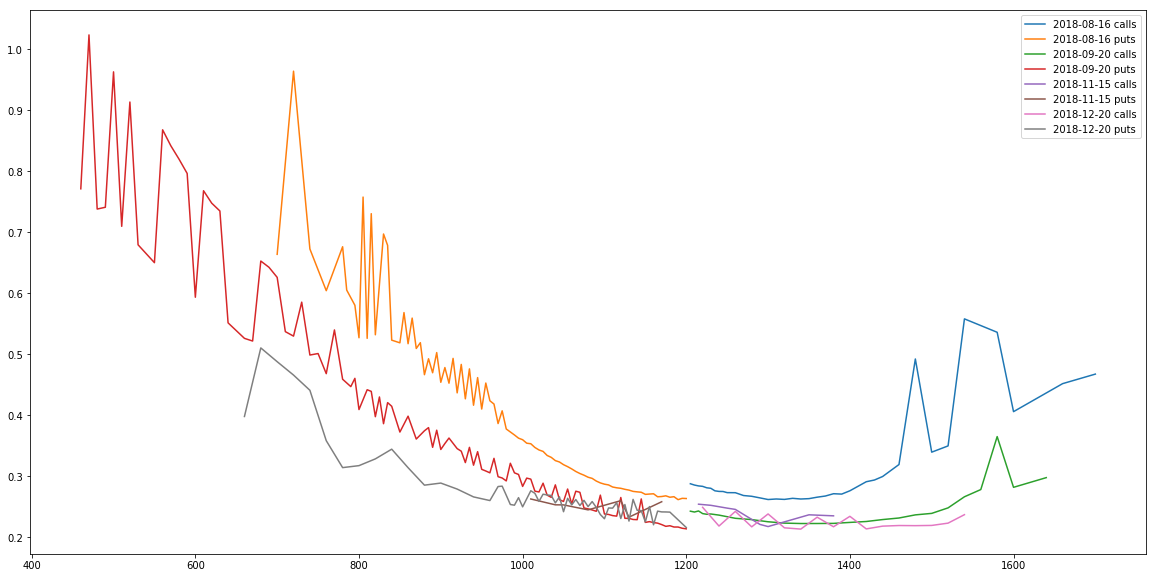

In [11]:
### Only OTM

# Prints all non-weeklies on one chart.

plt.gcf().clear()
plt.figure(figsize=(20,10))

### OTM calls and puts... (not so interesting)

for i in non_weeklies[:4]:
    
    print(i)
    
    iv = sym[sym['exp_dates'] == i]
    
    iv_put = iv[iv['type'] == 'put']
    iv_call = iv[iv['type'] == 'call']
    
    otm_put = iv_put[iv_put['inTheMoney'] == False]
    otm_call = iv_call[iv_call['inTheMoney'] == False]
    
    plt.plot(otm_call[['strike', 'impliedVolatility']].set_index('strike'), label=str(i) + ' calls')
    plt.plot(otm_put[['strike', 'impliedVolatility']].set_index('strike'), label=str(i) + ' puts')
    
# Size plot (change this to scale dynamically... like 2-3 sd)

#plt.ylim(0, 1.75)
#plt.xlim(sym_min, sym_max)
plt.legend()
plt.show()

### Plot is showing calls and puts on each side. ###

change
2018-08-16
2018-09-20
2018-11-15
2018-12-20


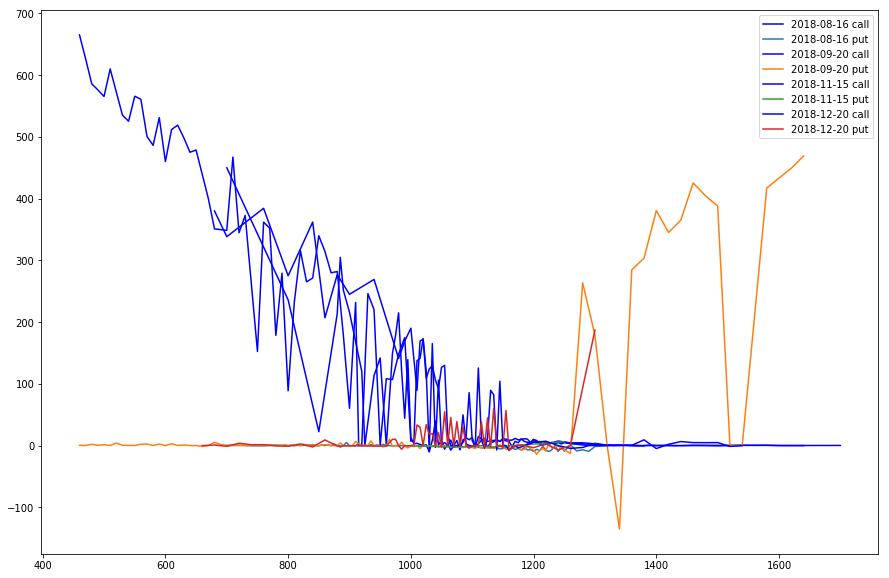

openInterest
2018-08-16
2018-09-20
2018-11-15
2018-12-20


<Figure size 432x288 with 0 Axes>

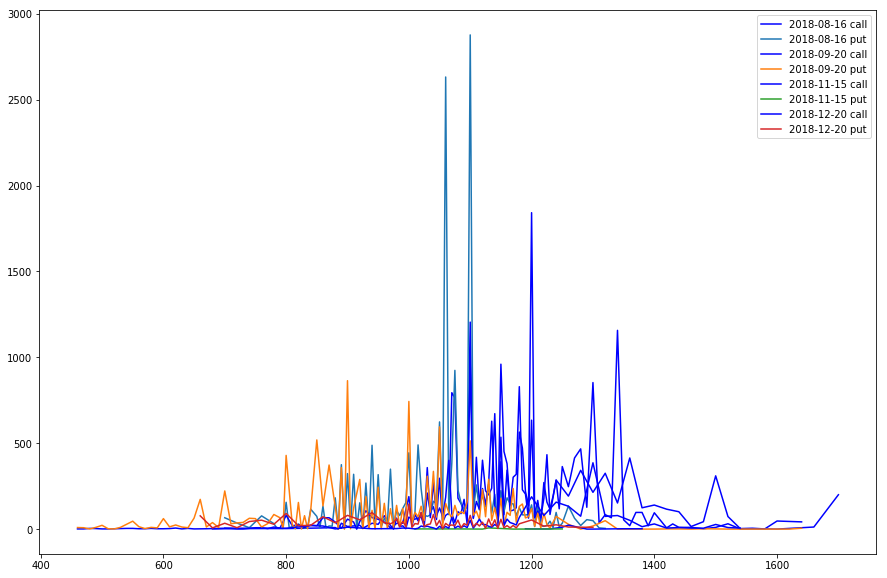

percentChange
2018-08-16
2018-09-20
2018-11-15
2018-12-20


<Figure size 432x288 with 0 Axes>

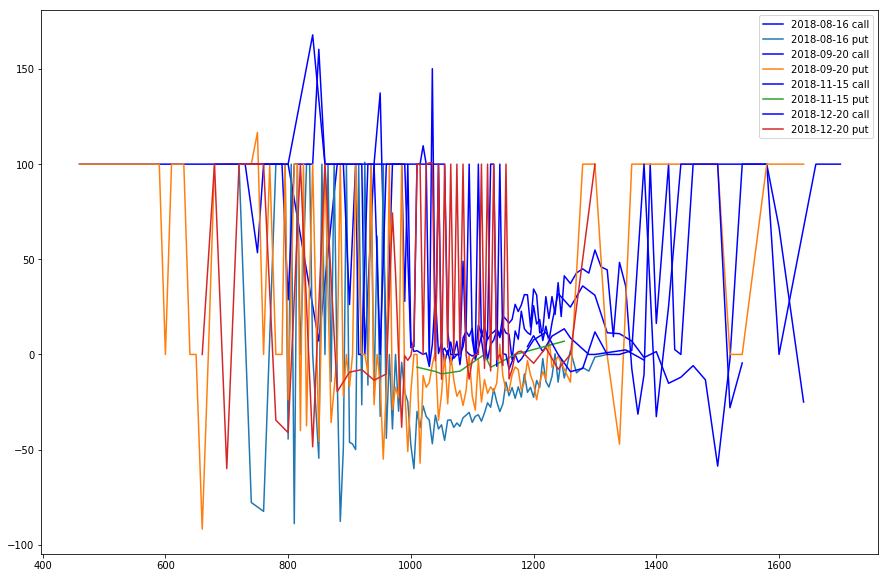

volume
2018-08-16
2018-09-20
2018-11-15
2018-12-20


<Figure size 432x288 with 0 Axes>

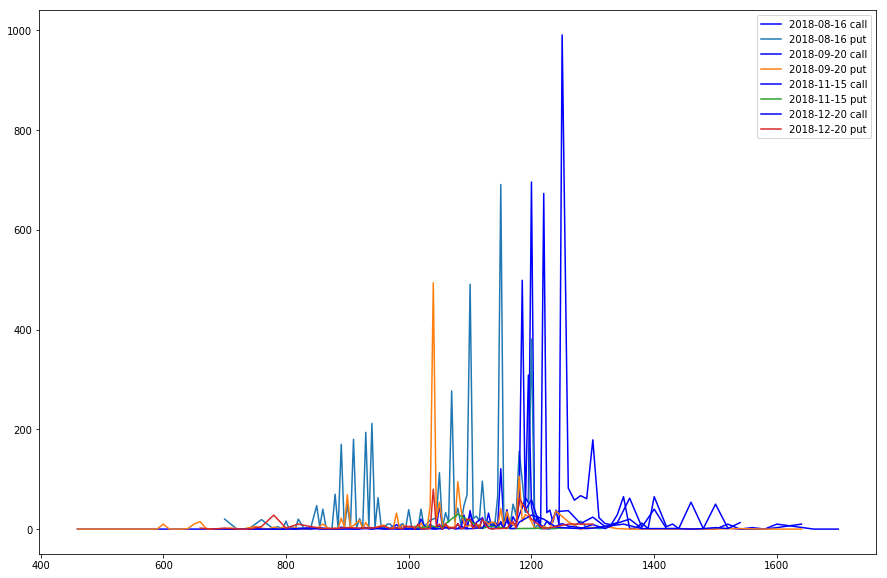

mid
2018-08-16
2018-09-20
2018-11-15
2018-12-20


<Figure size 432x288 with 0 Axes>

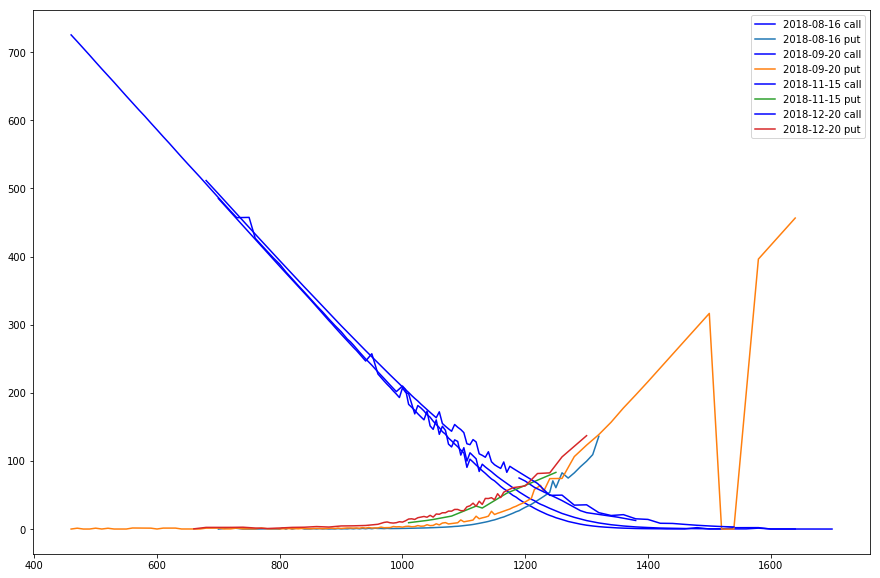

<Figure size 432x288 with 0 Axes>

In [12]:
### Let's print the OI and vol for each strike, and plot it out. ###

# 'change', 'inTheMoney' # use this to x out calls and puts you don't care about, 'openInterest', 'percentChange', 'volume'

for j in ['change', 'openInterest', 'percentChange', 'volume', 'mid']:
    
    plt.figure(figsize=(15,10))
    
    print(j)
    
    for i in non_weeklies[:4]:

        print(i)

        iv = sym[sym['exp_dates'] == i]

        iv_put = iv[iv['type'] == 'put']
        iv_call = iv[iv['type'] == 'call']

        plt.plot(iv_call[['strike', j]].set_index('strike'), label=str(i) + ' call', color='b')
        plt.plot(iv_put[['strike', j]].set_index('strike'), label = str(i) + ' put')

    # Size plot (change this to scale dynamically... like 2-3 sd)
    
    # Find the max and min
    # Find the min and max or ~sd's in price or delta
    
    # How do you plot the legend?
    
    #plt.ylim(0, 1.75)
    #plt.xlim(sym_min, sym_max)
    plt.legend()
    plt.show()
    plt.gcf().clear()

iv


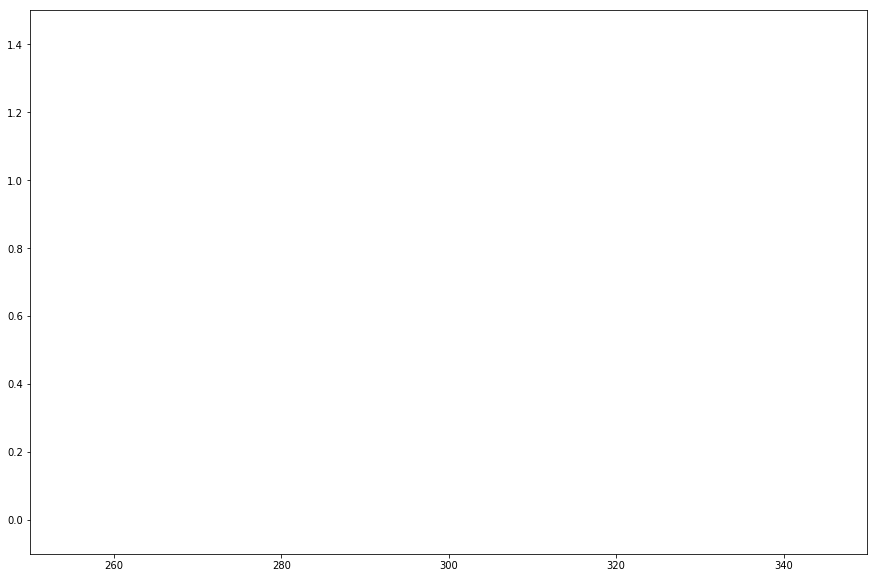

In [13]:
### PRINTING DIFF COLORS ###

plt.figure(figsize=(15, 10))

color = np.linspace(.4, .8, len(non_weeklies[:4]))

for i, j in zip(non_weeklies[:4], color):

        iv = sym[sym['exp_dates'] == i]
        iv_call = iv[iv['type'] == 'call']
        
        plt.plot(iv_call['strike'], iv_call['impliedVolatility'], lw=5, color = plt.cm.cool(j))
        
print('iv')
        
plt.xlim(250, 350)
plt.ylim(-.1, 1.5)
plt.show()    

<Figure size 432x288 with 0 Axes>

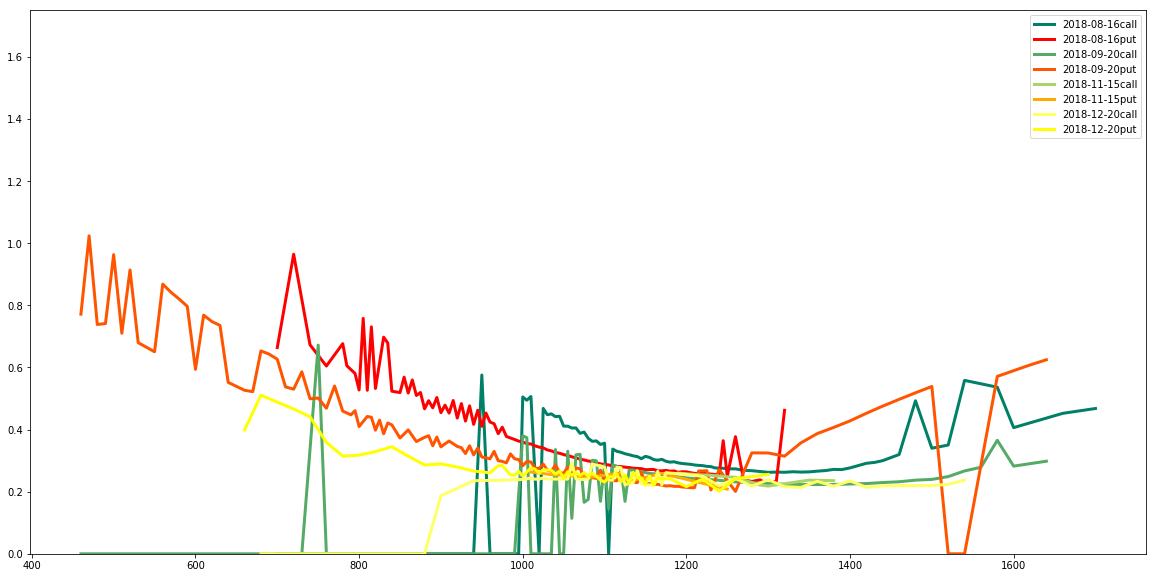

In [15]:
# Prints all non-weeklies on one chart.

plt.gcf().clear()
plt.figure(figsize=(20,10))

# Prints first 4 exp

color = np.linspace(0, 1, len(non_weeklies[:4]))

for i, j in zip(non_weeklies[:4], color):
    
    iv = sym[sym['exp_dates'] == i]
    
    iv_put = iv[iv['type'] == 'put']
    iv_call = iv[iv['type'] == 'call']
    
    plt.plot(iv_call[['strike', 'impliedVolatility']].set_index('strike'), label=str(i) + 'call', color = plt.cm.summer(j), lw=3)
    plt.plot(iv_put[['strike', 'impliedVolatility']].set_index('strike'), label=str(i) + 'put', color = plt.cm.autumn(j), lw=3)

plt.ylim(0, 1.75)
#plt.xlim(sym_min, sym_max)
plt.legend()
plt.show()


change


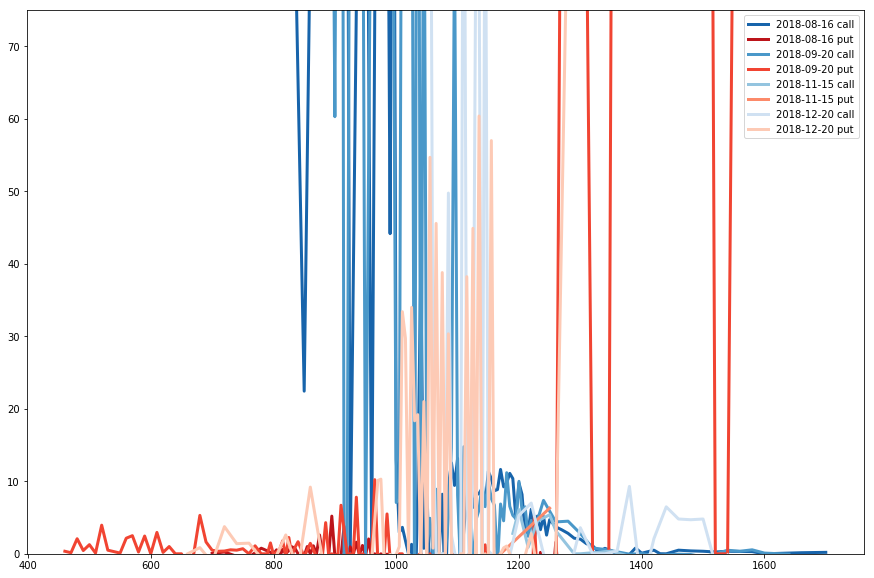


openInterest


<Figure size 432x288 with 0 Axes>

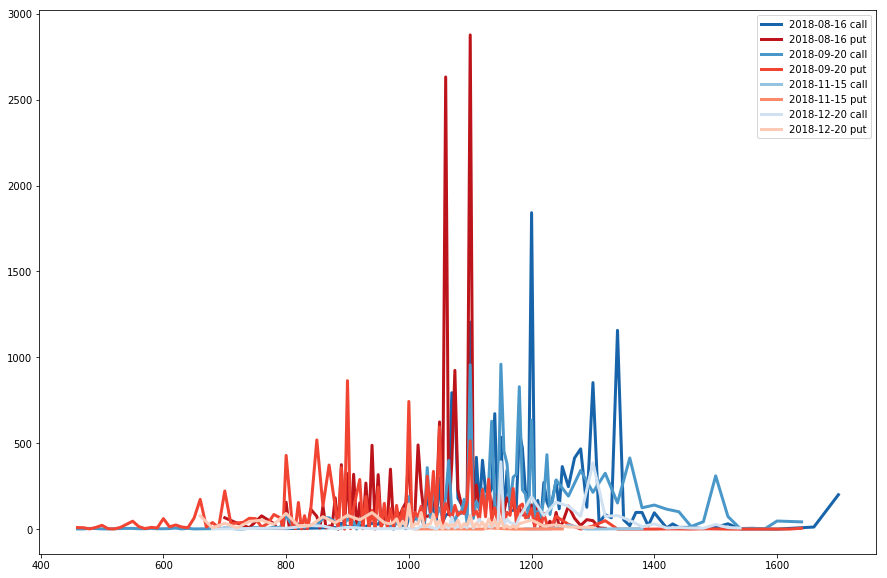


percentChange


<Figure size 432x288 with 0 Axes>

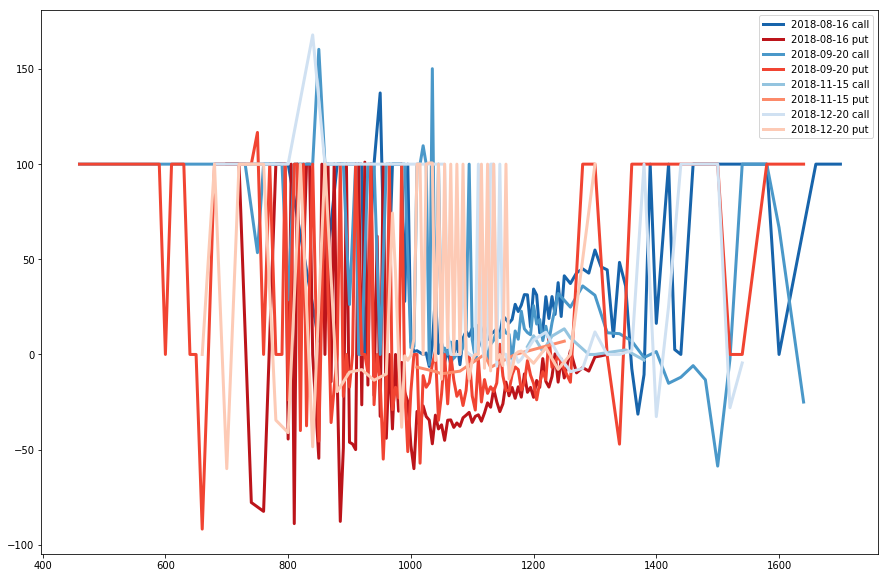


volume


<Figure size 432x288 with 0 Axes>

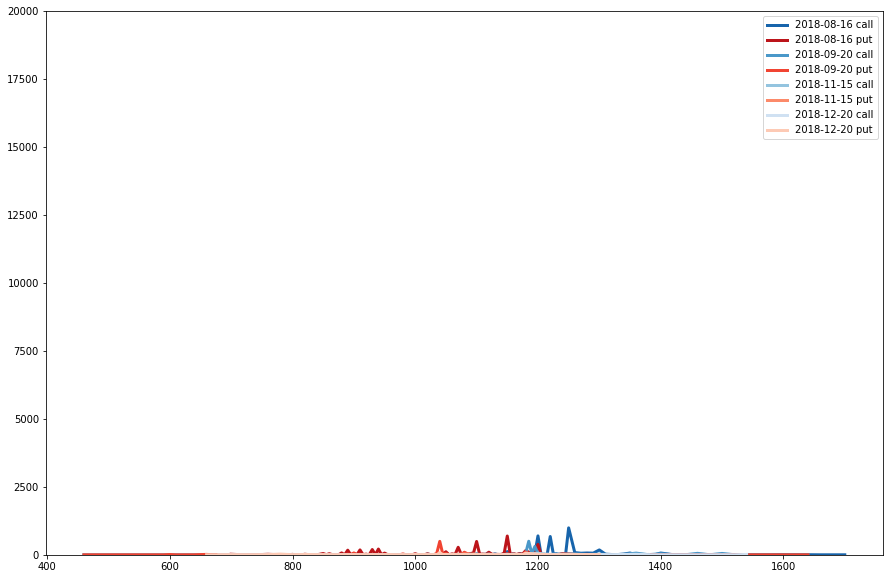


mid


<Figure size 432x288 with 0 Axes>

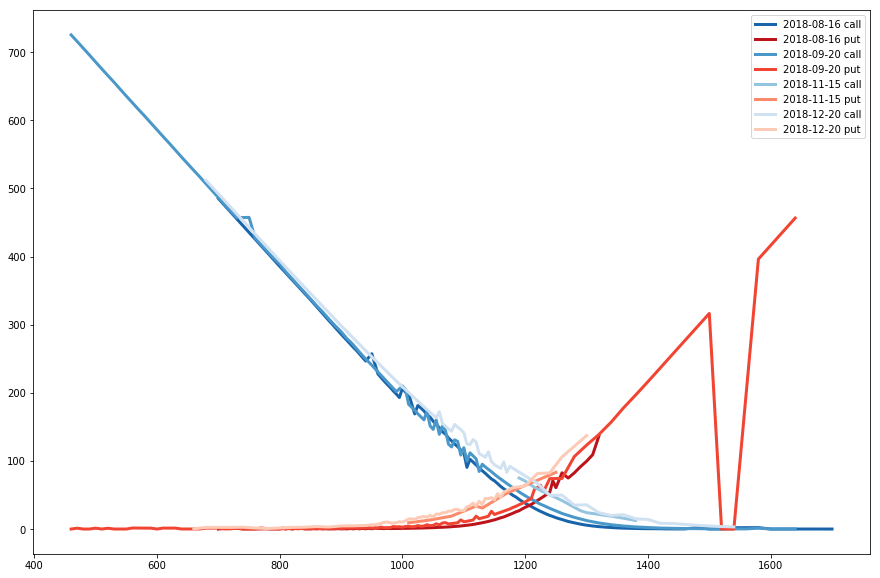


impliedVolatility


<Figure size 432x288 with 0 Axes>

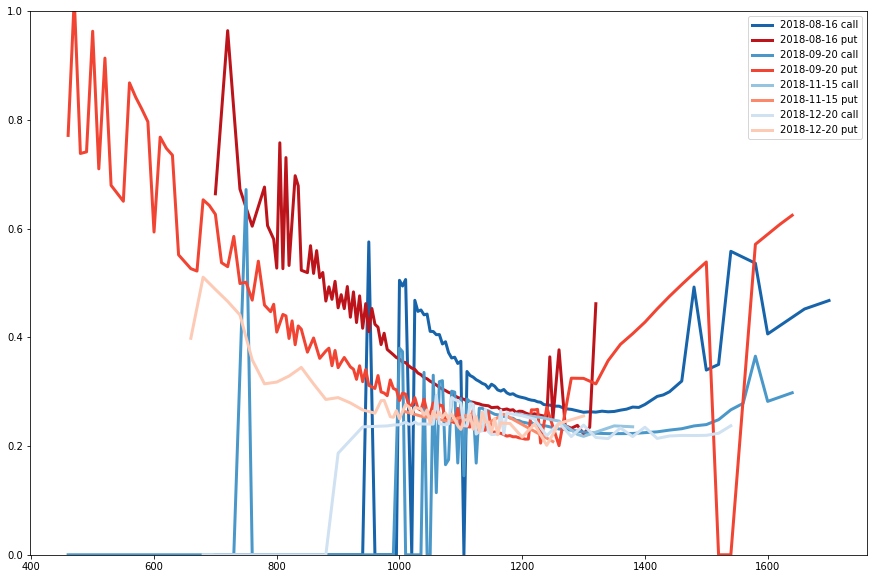

<Figure size 432x288 with 0 Axes>

In [16]:
### MAKE THE COLORS ###

### How do you make the more recent exp print in front?

for j in ['change', 'openInterest', 'percentChange', 'volume', 'mid', 'impliedVolatility']:
    
    plt.figure(figsize=(15,10))
    
    colors = np.linspace(.8, .2, len(non_weeklies[:4]))
    
    print()
    print(j)
    
    for i, k in zip(non_weeklies[:4], colors):

        iv = sym[sym['exp_dates'] == i]

        iv_put = iv[iv['type'] == 'put']
        iv_call = iv[iv['type'] == 'call']

        plt.plot(iv_call[['strike', j]].set_index('strike'), label=str(i) + ' call', color=plt.cm.Blues(k), lw = 3)
        plt.plot(iv_put[['strike', j]].set_index('strike'), label = str(i) + ' put', color=plt.cm.Reds(k), lw = 3)
    
    if j == 'volume':
        
        plt.ylim(0, 20000)
        
    if j == 'mid':
        
        #plt.ylim(0, 75)
        pass
        
    if j == 'change':
        
        plt.ylim(0, 75)
        
        
    if j == 'impliedVolatility':
        
        plt.ylim(0, 1)
    
    #plt.ylim(0, 1.75)
    #plt.xlim(200, 350)
    plt.legend()
    plt.show()
    plt.gcf().clear()